In [ ]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
print(data)

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [ ]:
hidden_dim = 64
layer = 2
# activation: ReLU
learning_rate = 0.01
optimizer_name = "Adam"

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN model with 2 layers 
class GCN(nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(dataset.num_features, hidden_dim)
    self.conv2 = GCNConv(hidden_dim, hidden_dim)
    self.linear = nn.Linear(hidden_dim, dataset.num_classes)

  def forward(self):
    x, edge_index = data.x, data.edge_index
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training = self.training)
    x = self.linear(x)
    return x

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


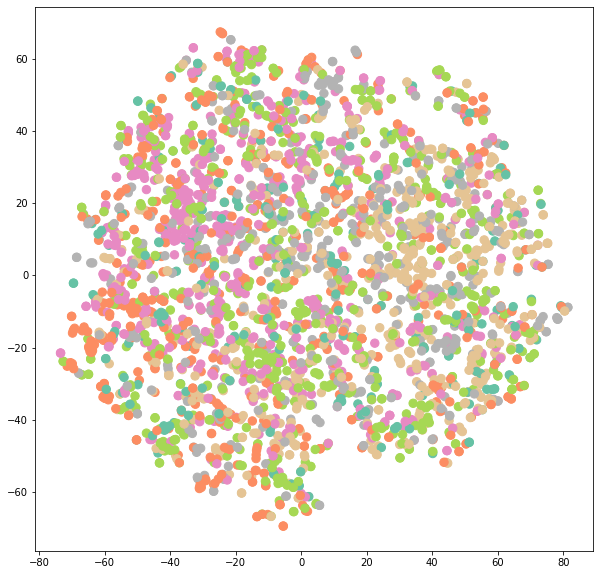

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

data = data
model = GCN()
criterion = nn.CrossEntropyLoss()
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
node_epochs = 200
# emb: (nNodes, hidden_dim)
# node_type: (nNodes,). Entries are torch.int64 ranged from 0 to num_class - 1
# For visualizationEntries are torch.int64 ranged from 0 to num_class - 1
# For visualization
def visualize(emb, node_type):
    z = TSNE(n_components=2).fit_transform(emb.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.scatter(z[:, 0], z[:, 1], s=70, c=node_type, cmap="Set2")
    plt.show()

model.train(False)
out = model()
visualize(out, data.y)

In [ ]:
train_errors = []
train_losses = []
test_errors = []

for epoch in range(node_epochs):
  model.train(True)

  optimizer.zero_grad()

  train_outputs = model()
  train_mask = data['train_mask']

  # train accuracy
  train_prediction = train_outputs[train_mask].max(1)[1]
  train_error = 1 - train_prediction.eq(data.y[train_mask]).sum().item() / train_mask.sum().item()
  train_errors.append(train_error)

  # train loss
  loss = criterion(train_outputs[train_mask], data.y[train_mask])
  train_losses.append(loss.item())

  # update
  loss.backward()
  optimizer.step()

  model.train(False)

  test_outputs = model()
  test_mask = data['test_mask']

  # test accuracy
  test_prediction = test_outputs[test_mask].max(1)[1]
  test_error = 1 - test_prediction.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
  test_errors.append(test_error)

print(train_errors[-1])
print(train_losses[-1])
print(test_errors[-1])

0.0
0.00518812844529748
0.382


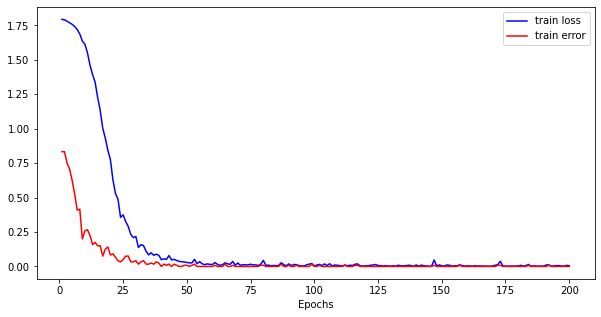

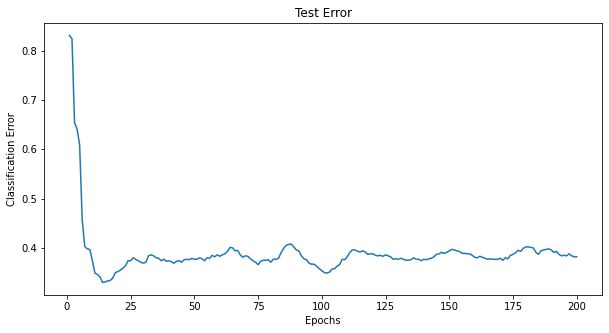

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1,node_epochs+1), train_losses, color = "blue", label = "train loss")
plt.plot(range(1,node_epochs+1), train_errors, color = "red", label = "train error")
plt.legend()
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Test Error")
plt.plot(range(1,node_epochs+1), test_errors)
plt.xlabel("Epochs")
plt.ylabel("Classification Error")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


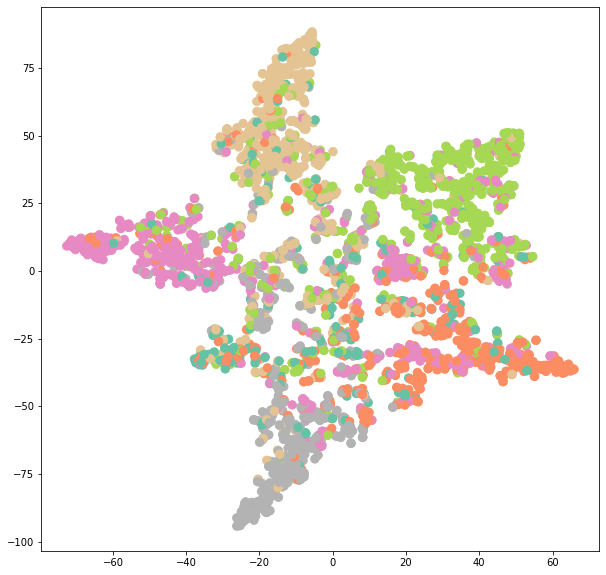

In [ ]:
model.train(False)
out = model()
visualize(out, data.y)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GINConv

# GIN model with 2 layers 
class GIN(torch.nn.Module):
  def __init__(self):
    super(GIN, self).__init__()
    self.conv1 = GINConv(nn.Linear(dataset.num_features, hidden_dim))
    self.conv2 = GINConv(nn.Linear(hidden_dim, hidden_dim))
    self.linear = Linear(hidden_dim, dataset.num_classes)

  def forward(self):
    x, edge_index = data.x, data.edge_index
    
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    # x = torch.cat((x1, x2), dim=1)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.linear(x)
    return x

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


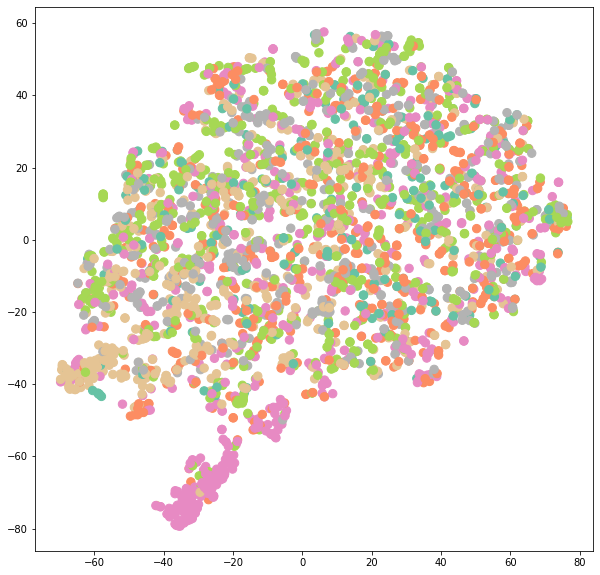

GIN(
  (conv1): GINConv(nn=Linear(in_features=3703, out_features=64, bias=True))
  (conv2): GINConv(nn=Linear(in_features=64, out_features=64, bias=True))
  (linear): Linear(in_features=64, out_features=6, bias=True)
)


In [ ]:
model = GIN()
criterion = nn.CrossEntropyLoss()
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
model.train(False)
out = model()
visualize(out, data.y)
print(model)

In [ ]:
train_errors = []
train_losses = []
test_errors = []

for epoch in range(node_epochs):
  model.train(True)

  optimizer.zero_grad()

  train_outputs = model()
  train_mask = data['train_mask']

  # train accuracy
  train_prediction = train_outputs[train_mask].max(1)[1]
  train_error = 1 - train_prediction.eq(data.y[train_mask]).sum().item() / train_mask.sum().item()
  train_errors.append(train_error)

  # train loss
  loss = criterion(train_outputs[train_mask], data.y[train_mask])
  train_losses.append(loss.item())

  # update
  loss.backward()
  optimizer.step()

  model.train(False)

  test_outputs = model()
  test_mask = data['test_mask']

  # test accuracy
  test_prediction = test_outputs[test_mask].max(1)[1]
  test_error = 1 - test_prediction.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
  test_errors.append(test_error)

print(train_errors[-1])
print(train_losses[-1])
print(test_errors[-1])

0.0
0.00489753158763051
0.366


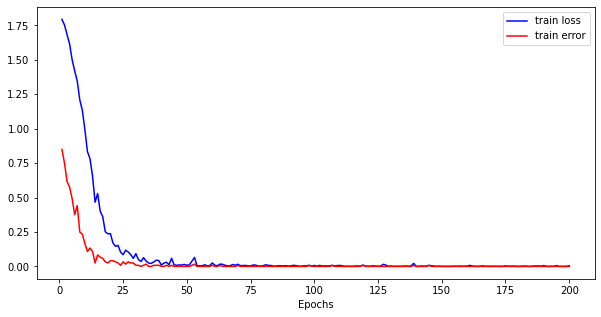

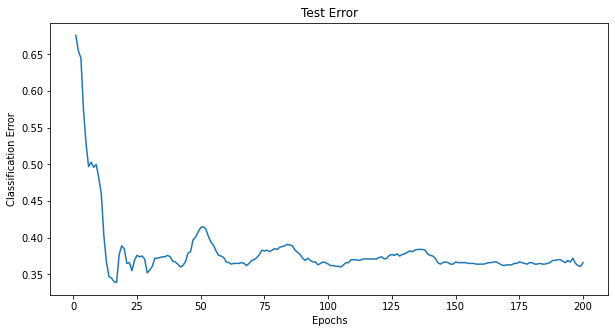

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1,node_epochs+1), train_losses, color = "blue", label = "train loss")
plt.plot(range(1,node_epochs+1), train_errors, color = "red", label = "train error")
plt.legend()
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Test Error")
plt.plot(range(1,node_epochs+1), test_errors)
plt.xlabel("Epochs")
plt.ylabel("Classification Error")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


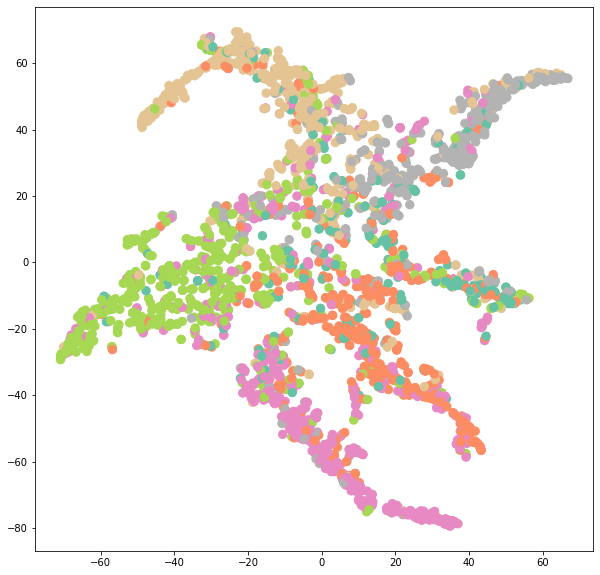

In [52]:
model.train(False)
out = model()
visualize(out, data.y)

In [53]:
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader

# dataset = KarateClub(transform=NormalizeFeatures())

dataset = TUDataset(root='data/TUDataset', name='MUTAG',transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
train_dataset = dataset[: int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.8): ]
print('==== train_dataset =====')
print(train_dataset)
print('==== test_dataset =====')
print(test_dataset)

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
==== train_dataset =====
MUTAG(150)
==== test_dataset =====
MUTAG(38)


In [54]:
batch_len = 1
training_loader = DataLoader(train_dataset, batch_size=batch_len, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_len, shuffle=True)

In [55]:
from torch_geometric.nn.glob import global_max_pool
class GIN_Graph(torch.nn.Module):
  def __init__(self):
    super(GIN_Graph, self).__init__()
    self.conv1 = GINConv(nn.Linear(dataset.num_features, hidden_dim))
    self.conv2 = GINConv(nn.Linear(hidden_dim, hidden_dim))
    self.linear = Linear(hidden_dim, dataset.num_classes)

  def forward(self, x, edge_index, batch_size):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = global_max_pool(x, batch_size)
    x = self.linear(x)
    return F.log_softmax(x, dim=1)

In [56]:
model = GIN_Graph()
criterion = nn.CrossEntropyLoss()
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
graph_epochs = 30
print(model)

GIN_Graph(
  (conv1): GINConv(nn=Linear(in_features=7, out_features=64, bias=True))
  (conv2): GINConv(nn=Linear(in_features=64, out_features=64, bias=True))
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


In [57]:
def train_one_epoch():
  train_total_loss = 0.
  train_total_correct = 0

  train_total_n = 0
  for data in training_loader:
    # Zero your gradients for every batch!
    optimizer.zero_grad()

    train_outputs = model(data.x, data.edge_index, data.batch)

    # train accuracy
    train_prediction = train_outputs.argmax(dim=1)
    train_total_correct += train_prediction.eq(data.y).sum().item()

    # train loss
    loss = criterion(train_outputs, data.y)
    train_total_loss += loss.item()

    # update
    loss.backward()
    optimizer.step()
    train_total_n += 1

  return train_total_loss/len(train_dataset), train_total_correct/len(train_dataset)

In [58]:
train_errors = []
train_losses = []
test_errors = []

for epoch in range(graph_epochs):
  model.train(True)

  train_avg_loss, train_accuracy = train_one_epoch()
  train_losses.append(train_avg_loss)
  train_errors.append(1 - train_accuracy)

  model.train(False)

  test_total_correct = 0
  for data in test_loader:
    test_outputs = model(data.x, data.edge_index, data.batch)
    
    # test correctness
    test_prediction = test_outputs.argmax(dim=1)
    test_total_correct += test_prediction.eq(data.y).sum().item()
  
  test_accuracy = test_total_correct/len(test_dataset)
  test_error = 1 - test_accuracy
  test_errors.append(test_error)

print(train_errors[-1])
print(train_losses[-1])
print(test_errors[-1])

0.19999999999999996
0.4364588512045642
0.1842105263157895


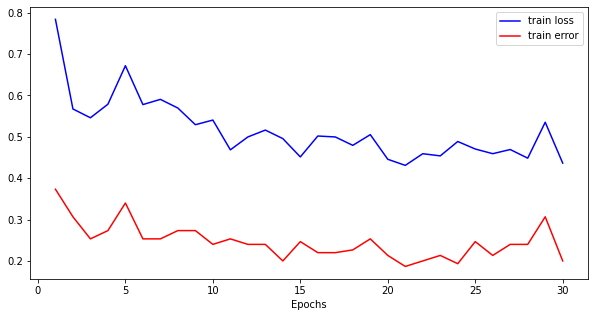

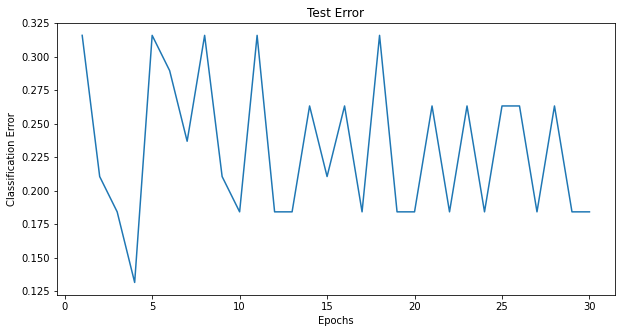

In [60]:
plt.figure(figsize=(10,5))
plt.plot(range(1,graph_epochs+1), train_losses, color = "blue", label = "train loss")
plt.plot(range(1,graph_epochs+1), train_errors, color = "red", label = "train error")
plt.legend()
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(10,5))
plt.title("Test Error")
plt.plot(range(1,graph_epochs+1), test_errors)
plt.xlabel("Epochs")
plt.ylabel("Classification Error")
plt.show()

In [ ]:
batch_len = 4
training_loader = DataLoader(train_dataset, batch_size=batch_len, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_len, shuffle=True)
model = GIN_Graph()
criterion = nn.CrossEntropyLoss()
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
graph_epochs = 30
print(model)

GIN_Graph(
  (conv1): GINConv(nn=Linear(in_features=7, out_features=64, bias=True))
  (conv2): GINConv(nn=Linear(in_features=64, out_features=64, bias=True))
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
train_errors = []
train_losses = []
test_errors = []

for epoch in range(graph_epochs):
  model.train(True)

  train_avg_loss, train_accuracy = train_one_epoch()
  train_losses.append(train_avg_loss)
  train_errors.append(1 - train_accuracy)

  model.train(False)

  test_total_correct = 0
  test_total_n = 0
  for data in test_loader:
    test_outputs = model(data.x, data.edge_index, data.batch)
    
    # test correctness
    test_prediction = test_outputs.argmax(dim=1)
    test_total_correct += test_prediction.eq(data.y).sum().item()
    test_total_n += 1
  
  test_accuracy = test_total_correct/len(test_dataset)
  test_error = 1 - test_accuracy
  test_errors.append(test_error)

print(train_errors[-1])
print(train_losses[-1])
print(test_errors[-1])

0.2733333333333333
0.12286722511053086
0.2894736842105263


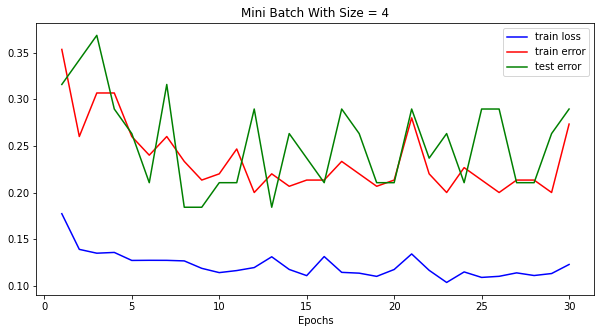

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Mini Batch With Size = 4')
plt.plot(range(1,graph_epochs+1), train_losses, color = "blue", label = "train loss")
plt.plot(range(1,graph_epochs+1), train_errors, color = "red", label = "train error")
plt.plot(range(1,graph_epochs+1), test_errors, color = "green", label = "test error")
plt.legend()
plt.xlabel("Epochs")
plt.show()

In [ ]:
batch_len = 8
training_loader = DataLoader(train_dataset, batch_size=batch_len, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_len, shuffle=True)
model = GIN_Graph()
criterion = nn.CrossEntropyLoss()
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
graph_epochs = 30
print(model)

GIN_Graph(
  (conv1): GINConv(nn=Linear(in_features=7, out_features=64, bias=True))
  (conv2): GINConv(nn=Linear(in_features=64, out_features=64, bias=True))
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
train_errors = []
train_losses = []
test_errors = []

for epoch in range(graph_epochs):
  model.train(True)

  train_avg_loss, train_accuracy = train_one_epoch()
  train_losses.append(train_avg_loss)
  train_errors.append(1 - train_accuracy)

  model.train(False)

  test_total_correct = 0
  test_total_n = 0
  for data in test_loader:
    test_outputs = model(data.x, data.edge_index, data.batch)
    
    # test correctness
    test_prediction = test_outputs.argmax(dim=1)
    test_total_correct += test_prediction.eq(data.y).sum().item()
    test_total_n += 1
  
  test_accuracy = test_total_correct/len(test_dataset)
  test_error = 1 - test_accuracy
  test_errors.append(test_error)

print(train_errors[-1])
print(train_losses[-1])
print(test_errors[-1])

0.20666666666666667
0.05432400047779083
0.26315789473684215


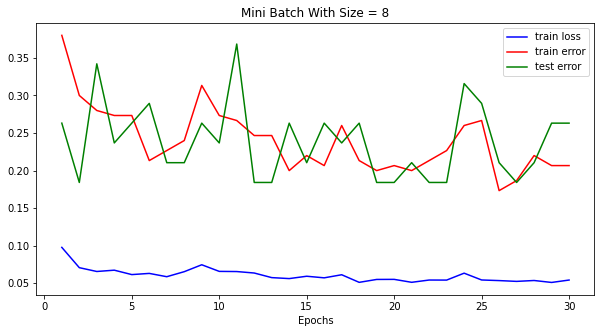

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Mini Batch With Size = 8')
plt.plot(range(1,graph_epochs+1), train_losses, color = "blue", label = "train loss")
plt.plot(range(1,graph_epochs+1), train_errors, color = "red", label = "train error")
plt.plot(range(1,graph_epochs+1), test_errors, color = "green", label = "test error")
plt.legend()
plt.xlabel("Epochs")
plt.show()

In [ ]:
batch_len = 16
training_loader = DataLoader(train_dataset, batch_size=batch_len, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_len, shuffle=True)
model = GIN_Graph()
criterion = nn.CrossEntropyLoss()
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
graph_epochs = 30
print(model)

GIN_Graph(
  (conv1): GINConv(nn=Linear(in_features=7, out_features=64, bias=True))
  (conv2): GINConv(nn=Linear(in_features=64, out_features=64, bias=True))
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
train_errors = []
train_losses = []
test_errors = []

for epoch in range(graph_epochs):
  model.train(True)

  train_avg_loss, train_accuracy = train_one_epoch()
  train_losses.append(train_avg_loss)
  train_errors.append(1 - train_accuracy)

  model.train(False)

  test_total_correct = 0
  test_total_n = 0
  for data in test_loader:
    test_outputs = model(data.x, data.edge_index, data.batch)
    
    # test correctness
    test_prediction = test_outputs.argmax(dim=1)
    test_total_correct += test_prediction.eq(data.y).sum().item()
    test_total_n += 1
  
  test_accuracy = test_total_correct/len(test_dataset)
  test_error = 1 - test_accuracy
  test_errors.append(test_error)

print(len(test_dataset))
print(train_errors[-1])
print(train_losses[-1])
print(test_errors[-1])

38
0.21999999999999997
0.030258887112140656
0.1842105263157895


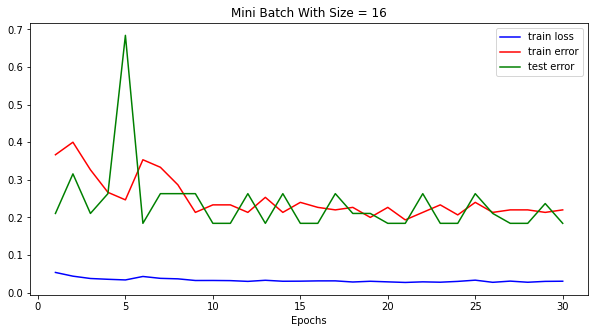

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Mini Batch With Size = 16')
plt.plot(range(1,graph_epochs+1), train_losses, color = "blue", label = "train loss")
plt.plot(range(1,graph_epochs+1), train_errors, color = "red", label = "train error")
plt.plot(range(1,graph_epochs+1), test_errors, color = "green", label = "test error")
plt.legend()
plt.xlabel("Epochs")
plt.show()